In [1]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")
#sys.path.append("/home/tinkerer/Poisson/")

import numpy as np
from collections import OrderedDict
from ccode.plotting import plot_gates
from ccode.gates import rectangular_gate, half_disk_gate
from ccode.finite_system import finite_system
import ccode.parameters as pm
import ccode.solvers as sl
import ccode.tools as tl
import itertools as it
import dask.bag as db
from scipy import constants
import matplotlib.pyplot as plt
from dask_quantumtinkerer import Cluster, cluster_options

import poisson
import kwant
from potential import gate_potential, linear_problem_instance
from plotting import plot_potential
from Hamiltonian import discrete_system_coordinates

from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    TwoDEGLayer,
)

from itertools import product
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
a = 10e-9

In [3]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/jtorresluna/trijunction_design/"

# Y-shaped geometry

#### Parameters

In [4]:
thickness_dielectric = 1
thickness_twoDEG = 1
thickness_gates = 3

grid_spacing_twoDEG = 0.5
grid_spacing_normal = 1
grid_spacing_dielectric = 1
grid_spacing_air = 5
grid_spacing_gate = grid_spacing_twoDEG

permittivity_metal = 5000
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

In [209]:
# one only needs to define the arm length L, and the channel width
L = 41
width = 12
gap = 4

R = L/np.sqrt(2)

In [210]:
R

28.991378028648448

In [211]:
# Boundaries within Poisson region
zmin = -0.5
zmax = 0.5
xmax = R
xmin = -xmax
ymin = 0
ymax = R + L - width
total_width = 2*xmax
total_length = ymax

#### Make gate polygons using Shapely

In [212]:
Y = unary_union(
    (
        Polygon(half_disk_gate(R=R, npts=3)).difference(Polygon(half_disk_gate(R=R-width*np.sqrt(2), npts=3))),
        Polygon(rectangular_gate(center=(0,R+L/2-width), width=width, length=L))
    )
)

gates = Polygon(rectangular_gate(center=(0, (R+L-width)/2), length=R+L-width-1,width=2*R)).difference(Y)

aux_rectangle_1 = rectangular_gate(length=R+2*gap, width=R+gap, center=(R/2, R/2-width/2))
aux_rectangle_2 = rectangular_gate(length=R+2*gap, width=R+gap, center=(-R/2, R/2-width/2))


def gate_coords(obj, difference=None, common=None, gap=None):

    if type(common) == np.ndarray:
        return np.round(np.array(list(obj.intersection(Polygon(common)).exterior.coords)), 2)

    else:
        if gap is not None:
            return np.round(np.array(list(obj.difference(Polygon(difference).buffer(gap)).exterior.coords)), 2)
        else:
            return np.round(np.array(list(obj.difference(Polygon(difference)).exterior.coords)), 2)


gates_vertex = [gate_coords(gates[0], common = aux_rectangle_2), 
                gate_coords(gates[2], difference = aux_rectangle_1), 
                gate_coords(gates[2], difference = aux_rectangle_2), 
                gate_coords(gates[1], common = aux_rectangle_1), 
                gate_coords(gates[0], difference = aux_rectangle_2, gap = gap), 
                gate_coords(gates[1], difference = aux_rectangle_1, gap = gap)]

gates_name = ['left_1', 'left_2', 'right_1', 'right_2', 'top_1', 'top_2']

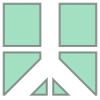

In [213]:
unary_union([Polygon(gate) for gate in gates_vertex])

In [214]:
np.round(np.ones(5),2)

array([1., 1., 1., 1., 1.])

#### Construct layout object for the Poisson solver

In [215]:
# Solve for Poisson system

layout = Layout(total_width,
                total_length,
                grid_width_air=grid_spacing_air,
                margin=(50, 50, 50),
                shift=(0, total_length/2, 0))

layout.add_layer(
    SimpleChargeLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG,
        add_to_previous_layer=False,
        fix_overlap=False,
        z_bottom=None
    ),
    center=True,
)

height = thickness_twoDEG / 2

layout.add_layer(
    SimpleChargeLayer(
        "Al2O3",
        thickness_dielectric,
        permittivity_Al2O3,
        grid_spacing_dielectric,
        add_to_previous_layer = False,
        fix_overlap = False,
        z_bottom = None
    )
)

height += thickness_dielectric


layout.add_layer(OverlappingGateLayer(thickness_gates,
                                      permittivity_metal,
                                      grid_spacing_gate,
                                      layer_name=gates_name,
                                      gate_objects=gates_vertex,
                                      remove_points=False,
                                      add_to_previous_layer=False,
                                      z_bottom=height,
                                      fix_overlap=True
                                     )
            )



In [216]:
height += thickness_gates + 1
layout.add_layer(
    SimpleChargeLayer("Al2O3_2", thickness_dielectric, permittivity_Al2O3, grid_spacing_dielectric,
                     add_to_previous_layer = False,
                     z_bottom = height, fix_overlap = False)
)

height += thickness_dielectric + 1
thickness_accumulation_gate = 2
layout.add_layer(PlanarGateLayer("global_accumul", 
                                 thickness_accumulation_gate, 
                                 permittivity_metal, 
                                 grid_spacing_gate, 
                                 gate_coords = [],
                                 second_layer = [],
                                 fix_overlap = False,
                                 z_bottom = height
                                )
                )

#### Build Poisson object

In [217]:
%%time

poisson_system = layout.build()

checking intersection
finished checking intersection
Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
CPU times: user 1min 16s, sys: 5.38 s, total: 1min 21s
Wall time: 1min 21s


In [218]:
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

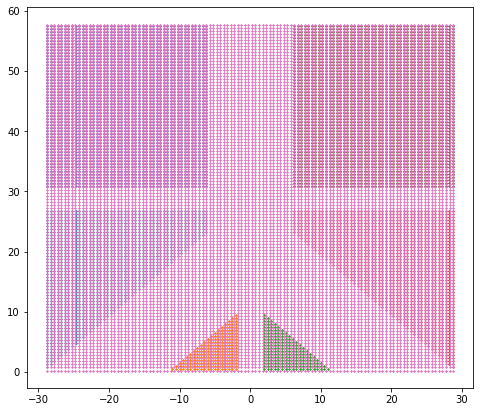

In [219]:
plt.figure(figsize = (8, 7))
for name, indices in voltage_regions.items():
    grid_to_plot = grid_points[indices][:, [0, 1]]
    plt.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)

#### LU decomposition of finite system

In [220]:
%%time

linear_problem = linear_problem_instance(poisson_system)

CPU times: user 4.21 s, sys: 387 ms, total: 4.6 s
Wall time: 4.58 s


In [221]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('charge', 'twoDEG')], boundaries=None
)

crds = site_coords[:, [0, 1]]
grid_spacing = grid_spacing_twoDEG
offset = crds[0]%grid_spacing

In [222]:
grid_points= poisson_system.grid.points

In [223]:
charge_regions = poisson_system.regions.charge.tag_points

In [224]:
voltage_regions = poisson_system.regions.voltage.tag_points
regions_to_add = []
for region in voltage_regions.keys():
    if region not in ['dirichlet_0', 'dirichlet_1', 'dirichlet_2', 'dirichlet_3']:
        regions_to_add.append(('voltage', region))
for region in charge_regions.keys():
    # if region not in ['air']:
    regions_to_add.append(('charge', region))

#### Verify the potential

In [225]:
#poisson_system.regions.voltage.tag_points

In [226]:
voltage_regions = list(poisson_system.regions.voltage.tag_points.keys())

In [227]:
depleted = -1e-3
acumulate = 4e-3

def voltage_dict(depleted, acumulate):
    voltages = {}

    voltages['left_1'] = depleted
    voltages['left_2'] = depleted

    voltages['right_1'] = depleted
    voltages['right_2'] = depleted

    voltages['top_1'] = depleted
    voltages['top_2'] = depleted

    voltages['global_accumul'] = acumulate

    return voltages

In [228]:
voltages = voltage_dict(depleted, acumulate)

In [229]:
%%time

charges = {}
clean_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltages,
        charges,
        offset=offset,
        grid_spacing=a
    )

CPU times: user 537 ms, sys: 11 ms, total: 548 ms
Wall time: 547 ms


In [230]:
coordinates = np.array(list(clean_potential.keys()))

x = coordinates[:, 0]
y = coordinates[:, 1]
width_plot = np.unique(x).shape[0]
X = x.reshape(width_plot, -1) / a
Y = y.reshape(width_plot, -1) / a
Z = np.round(np.array(list(clean_potential.values())).reshape(width_plot, -1) * -1, 4)

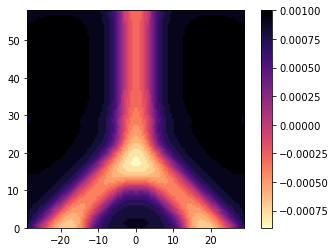

In [231]:
plt.figure()
plt.imshow(np.rot90(Z), extent = (xmin, xmax, ymin, ymax), cmap = 'magma_r')
plt.colorbar();

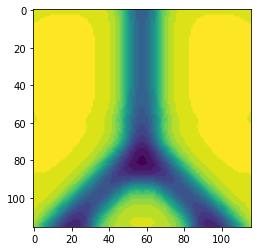

In [232]:
plt.imshow(np.rot90(Z))

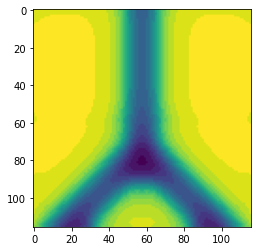

In [233]:
plt.imshow(np.rot90(Z[::-1,:]))

Text(0.5, 1.0, 'V(x,y) - V(-x,y)')

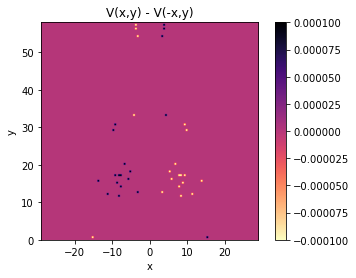

In [234]:
plt.imshow((np.rot90(Z[::-1,:])-np.rot90(Z)), extent = (xmin, xmax, ymin, ymax), cmap = 'magma_r')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("V(x,y) - V(-x,y)")

#### Plot the potential across (x, z) that slices at [y = ? nm]

In [235]:
import tinyarray as ta
import math

grid = np.array(list(clean_potential.keys()))
unique_y = np.unique(grid[:, 1])
chosen_y_coords = unique_y[np.multiply(unique_y >= 5 * a, unique_y <= 20*a)]

grid = np.array(list(clean_potential.keys()))
total_potential = []

coordinates = grid[grid[:, 1] == chosen_y_coords[0]]
for i in chosen_y_coords[1:]:
    coordinates = np.append(coordinates, grid[grid[:, 1] == i], axis = 0)
    
for element in coordinates:
    total_potential.append(clean_potential[ta.array(element)])
    
    
filter_nan = list(map(lambda x: False if math.isnan(x) else True, total_potential))
total_potential = np.array(total_potential)[filter_nan]
coordinates = coordinates[filter_nan]

grid = (coordinates / a) * 10

#### Plot the grid across (x, z) plane that slices y at [y = ? nm]

Text(0, 0.5, 'Z [nm]')

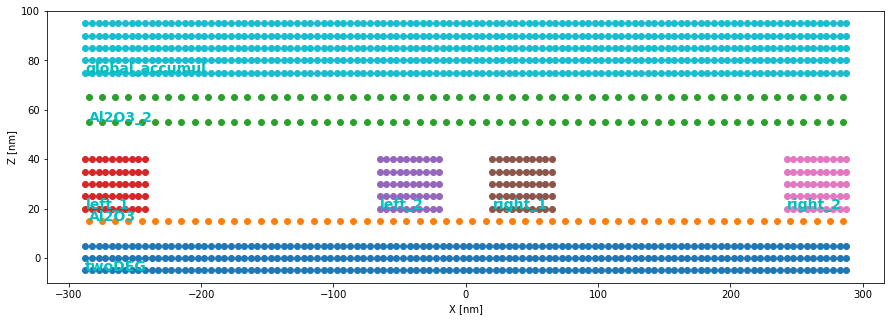

In [236]:
def filter_indices(points, minimum, maximum):
    data = np.unique(points[:, 1])
    chosen_y_coords = data[np.multiply(data >= minimum, data <= maximum)]
    if len(chosen_y_coords):
        return points[:, 1] == chosen_y_coords[0]
    else:
        return []
    
grid = grid_points.copy()

voltage_regions = {}
for key, indices in poisson_system.regions.voltage.tag_points.items():
    filtered_indices = filter_indices(grid[indices], 5, 20)
    voltage_regions[key] = indices[filtered_indices]
    
charge_regions = {}
for key, indices in poisson_system.regions.charge.tag_points.items():
    if key not in ['air', 'charge_default']:
        filtered_indices = filter_indices(grid[indices], 5, 20)
        charge_regions[key] = indices[filtered_indices]
        
fig, ax = plt.subplots(1, 1, figsize = (15, 5))

for name, indices in charge_regions.items():
    points = grid_points[indices][:, [0, 2]] * 10
    ax.scatter(points[:, 0], points[:, 1])
    if len(points)!= 0:    
        ax.annotate(name, points[0], c = 'c', alpha = 1.0, fontsize = 14,
                           fontweight = 'bold')
            
for name, indices in voltage_regions.items():
    points = grid_points[indices][:, [0, 2]] * 10
    ax.scatter(points[:, 0], points[:, 1])
    if len(points)!= 0:    
        ax.annotate(name, points[0], c = 'c', alpha = 1.0, fontsize = 14,
                           fontweight = 'bold')

ax.set_xlabel('X [nm]')
ax.set_ylabel('Z [nm]')

#### Build kwant object

In [237]:
# Build kwant system

R_a = R*a
width_a = width*a
l = 150 * a
w = 7 * a
boundaries = [xmin, xmax, ymin, ymax, min(grid_points[:, 2]), max(grid_points[:, 2])]
boundaries = np.array(boundaries) * a

geometry ={'nw_l': l, 'nw_w': w,
           's_w': boundaries[1] - boundaries[0],
           's_l': boundaries[3] - boundaries[2],
           'centers':[[-R_a+width_a/np.sqrt(2), 0],
                      [-(-R_a+width_a/np.sqrt(2)), 0], 
                      [0,boundaries[3]+l-a]
                     ]
          }

In [238]:
import importlib
import ccode.parameters
importlib.reload(ccode.parameters)

<module 'ccode.parameters' from '/home/tinkerer/trijunction-design/analysis/ccode/parameters.py'>

In [239]:
%%time

trijunction, f_params = finite_system(**geometry)
trijunction = trijunction.finalized()

CPU times: user 261 ms, sys: 3.09 ms, total: 265 ms
Wall time: 263 ms


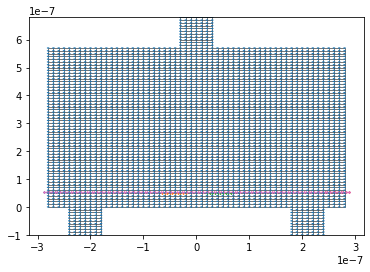

In [240]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax)
ax.set_ylim(-10*a, boundaries[3]+10*a)

for name, indices in voltage_regions.items():
    grid_to_plot = a*grid_points[indices][:, [0, 1]]
    ax.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)


In [258]:
mu = pm.bands[0]
params = pm.junction_parameters(m_nw=[mu, -2, mu], m_qd=0)

In [259]:
voltages

{'left_1': -0.005,
 'left_2': -0.005,
 'right_1': -0.005,
 'right_2': -0.005,
 'top_1': -0.005,
 'top_2': -0.005,
 'global_accumul': 0.035}

In [268]:
voltages = voltage_dict(depleted=-5e-3, acumulate=35e-3)
voltages['top_1'] = -18e-3
voltages['top_2'] = -18e-3

clean_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltages,
        charges,
        offset=offset,
        grid_spacing=a
    )

In [269]:
params.update(potential=clean_potential)

In [270]:
no_voltages = {key: 0 for key in list(voltages.keys())}

empty_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        no_voltages,
        charges,
        offset=offset,
        grid_spacing=a
    )

In [271]:
params.update(potential=empty_potential)

In [272]:
coordinates = np.array(list(clean_potential.keys()))

x = coordinates[:, 0]
y = coordinates[:, 1]
width_plot = np.unique(x).shape[0]
X = x.reshape(width_plot, -1) / a
Y = y.reshape(width_plot, -1) / a
Z = np.round(np.array(list(clean_potential.values())).reshape(width_plot, -1) * -1, 4)

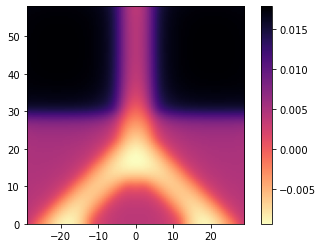

In [273]:
plt.figure()
plt.imshow(np.rot90(Z), extent = (xmin, xmax, ymin, ymax), cmap = 'magma_r')
plt.colorbar();

In [274]:
mu

0.0023960204649275973

(-1e-07, 9e-07)

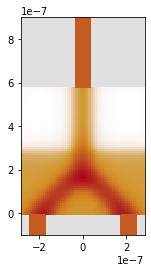

In [275]:
mu = pm.bands[0]
params = pm.junction_parameters(m_nw=[mu, mu, mu], m_qd=0)
params.update(potential=clean_potential)
f_mu = f_params(**params)['mu']

def plot_f_mu(i):
    x, y = trijunction.sites[i].pos
    return f_mu(x, y)

fig, ax = plt.subplots()
kwant.plotter.map(trijunction, plot_f_mu, ax=ax)
ax.set_ylim(-1e-7, 9e-7)

### Optimal phases

In [276]:
solver = sl.general_solver(geometries=[[trijunction, f_params]],
                           n=20,
                           base_parameters=params,
                           eigenvecs=False)


def wrap(arg):
    return solver(*arg)

In [278]:
args = list(it.product([0],ccode.parameters.phase_params()))
args_db = db.from_sequence(args)

### Left-Right coupling

In [279]:
%%time
with Cluster(options) as cluster:
    cluster.scale(10)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/8df9548affbc43c6ba9d2e7f40e6c90e/status
CPU times: user 21.6 s, sys: 534 ms, total: 22.1 s
Wall time: 2min 35s


In [282]:
spectra, couplings, wfs, peaks, widths = tl.coupling_data(result, n=20)

In [283]:
phis = np.linspace(0, 2, 100)
#max_phis = phis[np.array(peaks).flatten()]

Text(81.0, 0.5, '$E[\\mu eV]$')

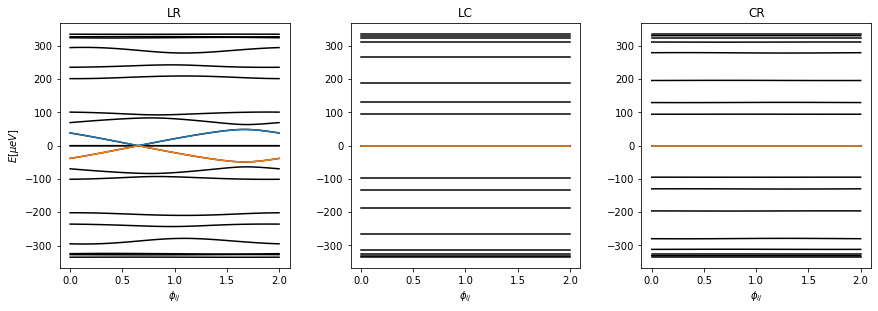

In [284]:
titles = ['LR', 'LC', 'CR']
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
fig.tight_layout(w_pad=3)
phis = np.linspace(0, 2, 100)
for i in range(3):
    for level in spectra[i].T:
        ax[i].plot(phis, 1e6*level, c='black')
    ax[i].plot(phis, 1e6*couplings[i])
    ax[i].plot(phis, -1e6*couplings[i])
    #ax[i].vlines(x=max_phis[i], ymin=-100, ymax=100)
    ax[i].set_xlabel(r'$\phi_{ij}$')
    ax[i].set_title(titles[i])
ax[0].set_ylabel(r'$E[\mu eV]$')

### Left-Center coupling

In [285]:
voltages = voltage_dict(depleted=-5e-3, acumulate=35e-3)
voltages['right_1'] = -18e-3
voltages['right_2'] = -18e-3

clean_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltages,
        charges,
        offset=offset,
        grid_spacing=a
    )

params.update(potential=clean_potential)

In [286]:
coordinates = np.array(list(clean_potential.keys()))

x = coordinates[:, 0]
y = coordinates[:, 1]
width_plot = np.unique(x).shape[0]
X = x.reshape(width_plot, -1) / a
Y = y.reshape(width_plot, -1) / a
Z = np.round(np.array(list(clean_potential.values())).reshape(width_plot, -1) * -1, 4)

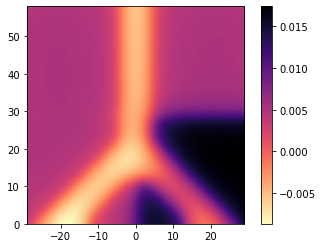

In [287]:
plt.figure()
plt.imshow(np.rot90(Z), extent = (xmin, xmax, ymin, ymax), cmap = 'magma_r')
plt.colorbar();

(-1e-07, 9e-07)

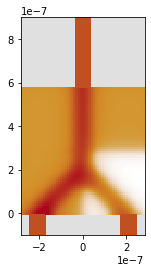

In [288]:
mu = pm.bands[0]
params = pm.junction_parameters(m_nw=[mu, mu, mu], m_qd=0)
params.update(potential=clean_potential)
f_mu = f_params(**params)['mu']

def plot_f_mu(i):
    x, y = trijunction.sites[i].pos
    return f_mu(x, y)

fig, ax = plt.subplots()
kwant.plotter.map(trijunction, plot_f_mu, ax=ax)
ax.set_ylim(-1e-7, 9e-7)

In [289]:
solver = sl.general_solver(geometries=[[trijunction, f_params]],
                           n=20,
                           base_parameters=params,
                           eigenvecs=False)


def wrap(arg):
    return solver(*arg)

In [290]:
args = list(it.product([0],ccode.parameters.phase_params()))
args_db = db.from_sequence(args)

In [291]:
%%time
with Cluster(options) as cluster:
    cluster.scale(10)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/375879db05e14d26b4419310feea1dad/status
CPU times: user 20.6 s, sys: 487 ms, total: 21 s
Wall time: 2min 31s


In [292]:
spectra, couplings, wfs, peaks, widths = tl.coupling_data(result, n=20)

In [293]:
phis = np.linspace(0, 2, 100)
#max_phis = phis[np.array(peaks).flatten()]

Text(81.0, 0.5, '$E[\\mu eV]$')

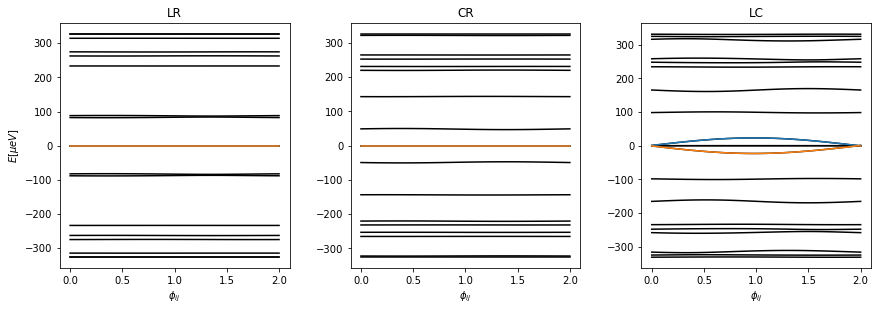

In [295]:
titles = ['LR', 'CR', 'LC']
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
fig.tight_layout(w_pad=3)
phis = np.linspace(0, 2, 100)
for i in range(3):
    for level in spectra[i].T:
        ax[i].plot(phis, 1e6*level, c='black')
    ax[i].plot(phis, 1e6*couplings[i])
    ax[i].plot(phis, -1e6*couplings[i])
    #ax[i].vlines(x=max_phis[i], ymin=-100, ymax=100)
    ax[i].set_xlabel(r'$\phi_{ij}$')
    ax[i].set_title(titles[i])
ax[0].set_ylabel(r'$E[\mu eV]$')

### Center-Right coupling

In [296]:
voltages = voltage_dict(depleted=-5e-3, acumulate=35e-3)
voltages['left_1'] = -18e-3
voltages['left_2'] = -18e-3

clean_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltages,
        charges,
        offset=offset,
        grid_spacing=a
    )

params.update(potential=clean_potential)

In [297]:
coordinates = np.array(list(clean_potential.keys()))

x = coordinates[:, 0]
y = coordinates[:, 1]
width_plot = np.unique(x).shape[0]
X = x.reshape(width_plot, -1) / a
Y = y.reshape(width_plot, -1) / a
Z = np.round(np.array(list(clean_potential.values())).reshape(width_plot, -1) * -1, 4)

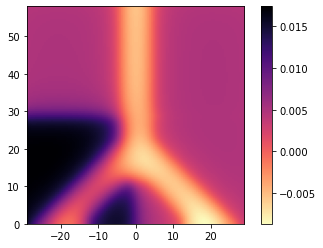

In [298]:
plt.figure()
plt.imshow(np.rot90(Z), extent = (xmin, xmax, ymin, ymax), cmap = 'magma_r')
plt.colorbar();

(-1e-07, 9e-07)

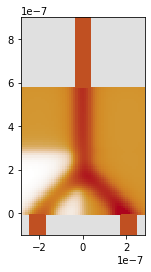

In [299]:
mu = pm.bands[0]
params = pm.junction_parameters(m_nw=[mu, mu, mu], m_qd=0)
params.update(potential=clean_potential)
f_mu = f_params(**params)['mu']

def plot_f_mu(i):
    x, y = trijunction.sites[i].pos
    return f_mu(x, y)

fig, ax = plt.subplots()
kwant.plotter.map(trijunction, plot_f_mu, ax=ax)
ax.set_ylim(-1e-7, 9e-7)

In [300]:
solver = sl.general_solver(geometries=[[trijunction, f_params]],
                           n=20,
                           base_parameters=params,
                           eigenvecs=False)


def wrap(arg):
    return solver(*arg)

In [301]:
args = list(it.product([0],ccode.parameters.phase_params()))
args_db = db.from_sequence(args)

In [302]:
%%time
with Cluster(options) as cluster:
    cluster.scale(10)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/e961413546104b99a02c917fabe54a69/status
CPU times: user 20 s, sys: 320 ms, total: 20.4 s
Wall time: 2min 35s


In [303]:
spectra, couplings, wfs, peaks, widths = tl.coupling_data(result, n=20)

In [304]:
phis = np.linspace(0, 2, 100)
#max_phis = phis[np.array(peaks).flatten()]

Text(81.0, 0.5, '$E[\\mu eV]$')

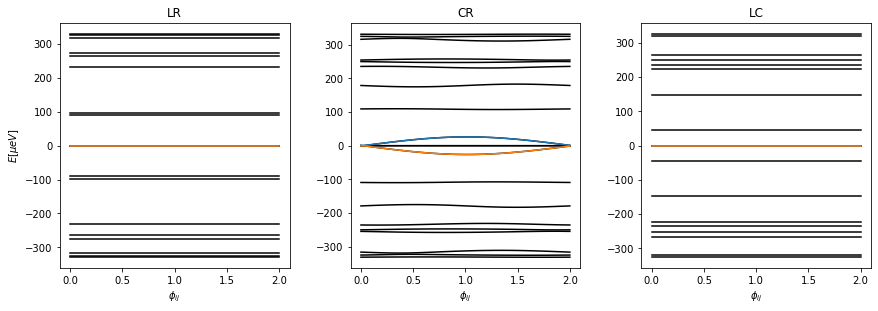

In [305]:
titles = ['LR', 'CR', 'LC']
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
fig.tight_layout(w_pad=3)
phis = np.linspace(0, 2, 100)
for i in range(3):
    for level in spectra[i].T:
        ax[i].plot(phis, 1e6*level, c='black')
    ax[i].plot(phis, 1e6*couplings[i])
    ax[i].plot(phis, -1e6*couplings[i])
    #ax[i].vlines(x=max_phis[i], ymin=-100, ymax=100)
    ax[i].set_xlabel(r'$\phi_{ij}$')
    ax[i].set_title(titles[i])
ax[0].set_ylabel(r'$E[\mu eV]$')

In [190]:
ens, vecs = wrap(args[2])

In [191]:
density = kwant.operator.Density(trijunction, np.eye(4))

In [192]:
kwant.plotter.density(trijunction, density(vecs[4]));

IndexError: list index out of range

In [327]:
ens

array([-3.83651991e-05, -6.89795364e-08, -3.38753459e-08,  3.38753460e-08,
        6.89795364e-08,  3.83651991e-05])

#### Define potential

In [35]:
grid_points = poisson_system.grid.points

In [36]:
poisson_system.regions.mixed.tag_points

{}

In [37]:
left1 = grid_points[poisson_system.regions.voltage.tag_points['left_1']]
twodeg = grid_points[poisson_system.regions.mixed.tag_points['twoDEG']]

KeyError: 'twoDEG'

In [ ]:
min(left1[:, 2]) - max(twodeg[:, 2])